# Research Replication: Unsupervised Learning of Digit Recognition Using STDP (Part 2)


In our last tutorial, we designed an SNN to classify digits. We used the MNIST dataset for training. However, we used a scaled down model for illustration. In this notebook, we're going to scale up the model a bit (though not to the full scale in the paper). We are going to use {glue:}`NUM_NEURONS` excitatory and inhibitory neurons, {glue:}`DIGIT_WIDTH`x{glue:}`DIGIT_HEIGHT` digits, and pre-trained weights (from [here](https://github.com/peter-u-diehl/stdp-mnist)).

First, let's take a look at what our pre-trained STDP weights look like. Below, in a grid, we can see what the input weights for all {glue:}`NUM_NEURONS` neurons look like.

In [1]:
from myst_nb import glue
import numpy as np

np.random.seed(0)

NUM_NEURONS = 400
NUM_NEURON_COLS = 20
NUM_NEURON_ROWS = 20

DIGIT_WIDTH =28
DIGIT_HEIGHT=28
DIGIT_SIZE=DIGIT_WIDTH*DIGIT_HEIGHT

glue("NUM_NEURONS", NUM_NEURONS, display=False)
glue("NUM_NEURON_COLS", NUM_NEURON_COLS, display=False)
glue("NUM_NEURON_ROWS", NUM_NEURON_ROWS, display=False)
glue("DIGIT_SIZE", DIGIT_SIZE, display=False)
glue("DIGIT_WIDTH", DIGIT_WIDTH, display=False)
glue("DIGIT_HEIGHT", DIGIT_HEIGHT, display=False)

def poisson_fire(values, min_value=0, max_value=255, min_rate=0, max_rate=10, dt=0.001):
    relativeValues = (values - min_value) / (max_value - min_value)
    relativeRates = min_rate + relativeValues * (max_rate - min_rate)
    probsOfFire = relativeRates * dt

    firings = np.random.rand(*values.shape) < probsOfFire
    return firings / dt

class SynapseCollection:
    def __init__(self, n=1, tau_s=0.05, t_step=0.001):
        self.n = n
        self.a = np.exp(-t_step / tau_s)  # Decay factor for synaptic current
        self.b = 1 - self.a  # Scale factor for input current

        self.voltage = np.zeros(n)  # Initial voltage of neurons
    
    def step(self, inputs):
        self.voltage = self.a * self.voltage + self.b * inputs

        return self.voltage

class STDPWeights:
    def __init__(self, numPre, numPost, tau_plus = 0.03, tau_minus = 0.03, a_plus = 0.1, a_minus = 0.11, g_min=0, g_max=1):
        self.numPre = numPre
        self.numPost = numPost
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.a_plus = a_plus
        self.a_minus = a_minus
        self.x = np.zeros(numPre)
        self.y = np.zeros(numPost)

        self.g_min = g_min
        self.g_max = g_max
        self.w = np.random.uniform(g_min, g_max, (numPre, numPost)) / numPost # Initialize weights


    def step(self, t_step):
        self.x = self.x * np.exp(-t_step/self.tau_plus)
        self.y = self.y * np.exp(-t_step/self.tau_minus)

    def updateWeights(self, preOutputs, postOutputs):
        self.x += (preOutputs  > 0) * self.a_plus
        self.y -= (postOutputs > 0) * self.a_minus

        alpha_g = self.g_max - self.g_min # Scaling factor for weight updates

        preSpikeIndices = np.where(preOutputs > 0)[0]   # Indices of pre-synaptic   spiking neurons
        postSpikeIndices = np.where(postOutputs > 0)[0]

        for ps_idx in preSpikeIndices:
            self.w[ps_idx] += alpha_g * self.y
            self.w[ps_idx] = np.clip(self.w[ps_idx], self.g_min, self.g_max)

        for ps_idx in postSpikeIndices:
            self.w[:, ps_idx] += alpha_g * self.x
            self.w[:, ps_idx] = np.clip(self.w[:, ps_idx], self.g_min, self.g_max)

class LIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        # self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.voltage = np.random.uniform(0, 1, n)  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        # self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        # self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        self.gain = np.ones(n)
        self.bias = np.zeros(n)
        
        # Initialize random encoders
        # self.encoders = np.random.randn(n, self.dim)
        # self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]
        self.encoders = np.ones((n, self.dim))

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=0) / self.n

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes

class ALIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0,
                 tau_inh=0.05, inc_inh=1.0 # <--- ADDED
                 ):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation

        self.inh = np.zeros(n)  # <--- ADDED
        self.tau_inh = tau_inh  # <--- ADDED
        self.inc_inh = inc_inh  # <--- ADDED
        
        # Initialize state variables
        # self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.voltage = np.random.uniform(0, 1, n)  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        # self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        # self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        self.gain = np.ones(n)
        self.bias = np.zeros(n)
        
        # Initialize random encoders
        # self.encoders = np.random.randn(n, self.dim)
        # self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]
        self.encoders = np.ones((n, self.dim))

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)
        self.inh = np.zeros(self.n)  # <--- ADDED

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=0) / self.n

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th + self.inh  # <--- ADDED + self.inh
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        self.inh = self.inh * np.exp(-dt / self.tau_inh) + self.inc_inh * (self.output > 0)  # <--- ADDED

        return self.output  # Return the output spikes


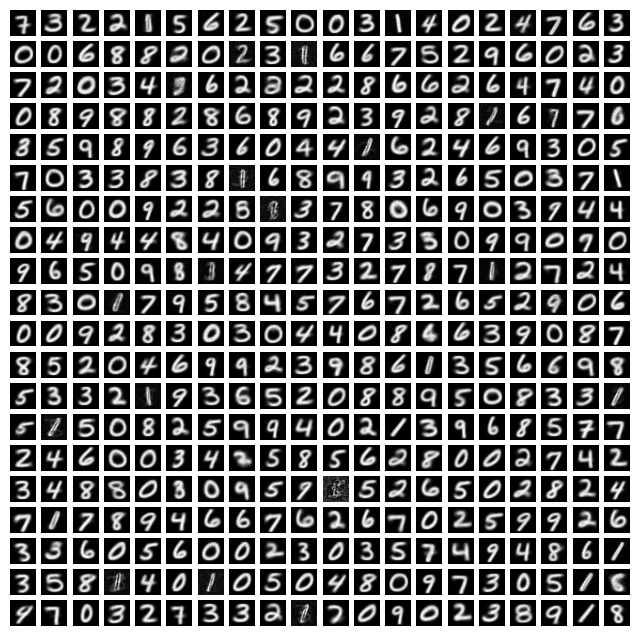

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

with open("../_static/datasets/xeae.json") as f:
    xeae = np.array(json.loads(f.read()))

fig, axs = plt.subplots(NUM_NEURON_ROWS, NUM_NEURON_COLS, figsize=(8, 8))
for i in range(NUM_NEURONS):
    ax = axs[i // NUM_NEURON_COLS, i % NUM_NEURON_COLS]
    ax.imshow(xeae[:, i].reshape(DIGIT_WIDTH, DIGIT_HEIGHT), cmap="gray")
    ax.axis("off")

As you can see, most of these weights look like clearly discernable numbers. Each neuron is responsive to a particular digit (and a particularly way of drawing that digit). Each of these neurons is labeled according to the digit it responds to but we'll pre-label them all.

We are also going to use pre-set firing thresholds for our excitatory neurons' ALIFs. When we're actually running our network, we will "freeze" both the STDP weights and the excitatory ALIFs' firing thresholds.

In [3]:
import zipfile
import json
import itertools
import random
from myst_nb import glue

random.seed(0)

def dataGenerator(path):
    with zipfile.ZipFile(path) as train_zip:
        with train_zip.open('index.json') as index_file:
            idx_info = json.loads(index_file.read())
            files = idx_info['files']
            N = idx_info['N']
            i = 0
            
            for fname in files:
                with train_zip.open(fname) as f:
                    data = json.loads(f.read())
                    images = data['images']
                    labels = data['labels']
                    for img, label in zip(images, labels):
                        yield (img, label)
                        i += 1
                        if i >= N: break          

testDataGenerator = dataGenerator('../_static/datasets/test-chunked.zip')

In [4]:
with open('../_static/datasets/theta.json') as theta_file:
    theta = json.loads(theta_file.read())
with open('../_static/datasets/neuron_labels.json') as labels_file:
    labels = json.loads(labels_file.read())

NUM_EXCITATORY = 400
TIME_TO_SHOW_IMAGES = 0.55 # seconds
TIME_TO_SHOW_BLANK  = 0.15 # seconds

# print(xeae)
t_step = 0.001  # Time step for the simulation
synapses = SynapseCollection(n=DIGIT_SIZE, tau_s=0.1, t_step=t_step)  # Synapse collection for input connections

# STDP (Spike-Timing-Dependent Plasticity) weight matrix between input and excitatory neurons
# stdp = STDPWeights(numPre=DIGIT_SIZE, numPost=NUM_EXCITATORY, g_min=-0.1, g_max=1.1)

# Inhibitory neurons and their corresponding post-synaptic potential (PSP) collection
inhibitory_neurons = LIF(n=NUM_EXCITATORY, t_step=t_step)
inhibitory_psp = SynapseCollection(n=NUM_EXCITATORY, t_step=t_step, tau_s=0.5)
inhibitory_outp = np.zeros(NUM_EXCITATORY)  # Initialize inhibitory output array

# Excitatory neurons and their corresponding PSP collection
excitatory_neurons = ALIF(n=NUM_EXCITATORY, t_step=t_step, tau_inh=1.1)
excitatory_neurons.inh = np.array(theta)
excitatory_psp = SynapseCollection(n=NUM_EXCITATORY, t_step=t_step, tau_s=0.2)

# Function to perform a simulation step
def step(inp, max_input_rate):
    global inhibitory_outp
    input_spikes = poisson_fire(np.array(inp), dt=t_step, min_rate=0.01, max_rate=max_input_rate)  # Generate input spikes
    input_psp = synapses.step(input_spikes)  # Step the input synapses to get PSP

    # stdp.step(t_step)  # Step the STDP mechanism
    # stdp.updateWeights(input_spikes, excitatory_neurons.output)  # Update weights based on input and output spikes

    # uses xeae as weights rather than stdp (assuming fixed weights)

    excitatory_inp = input_psp @ xeae + np.clip(inhibitory_outp * -1 / NUM_EXCITATORY, a_max=0, a_min=None)  # Calculate excitatory input combining synapse output and inhibitory output
    excitatory_spikes = excitatory_neurons.step(excitatory_inp)  # Step excitatory neurons to get their spikes

    excitatory_outp = excitatory_psp.step(excitatory_spikes)  # Update the excitatory post-synaptic potential

    inhibitory_spikes = inhibitory_neurons.step(excitatory_outp)  # Step inhibitory neurons using excitatory output
    # print(input_psp@stdp.w, excitatory_inp, excitatory_spikes, excitatory_outp, inhibitory_spikes)
    raw_inhibitory_outp = inhibitory_psp.step(inhibitory_spikes)  # Update the inhibitory post-synaptic potential
    total_inhibitory_outp = np.sum(raw_inhibitory_outp)  # Calculate the total inhibitory output
    inhibitory_outp = total_inhibitory_outp * np.ones(NUM_EXCITATORY) - raw_inhibitory_outp  # Calculate the inhibitory output for each neuron

    return excitatory_spikes > 0

Then, we can run an example of our network classifying a new digit, highlighting the neuron(s) that fire most below (indicating that those are the neurons that "recognized" the digit).

Predicted Label: 7, True Label: 7


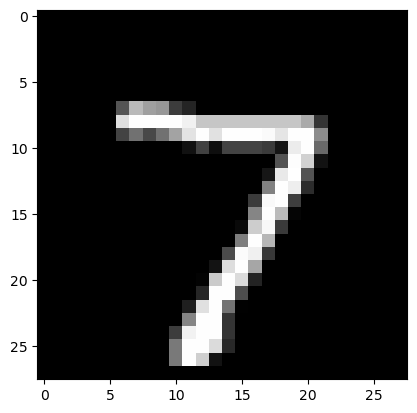

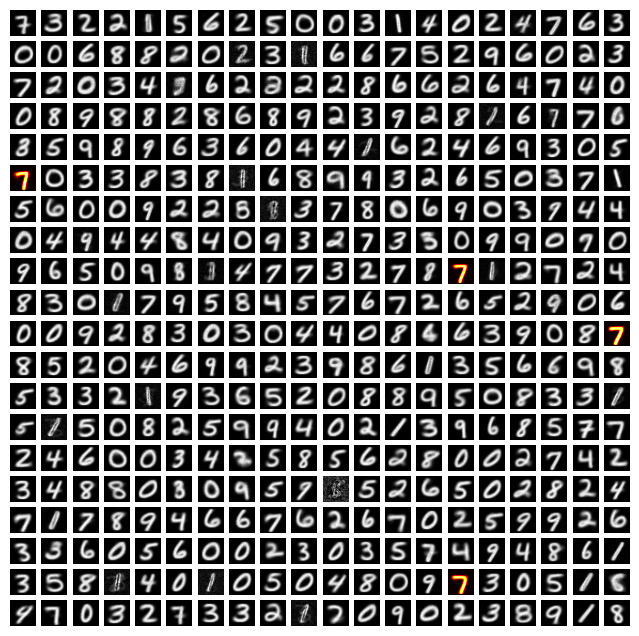

In [5]:

def run_simulation(num_images=1):
    for _ in range(num_images):
        current_image, label = next(testDataGenerator)  # Get the next image and label from the data generator

        total_fires = 0  # Initialize the total number of fires
        max_input_rate = 0.2  # Initial maximum input firing rate
        all_fires = np.zeros(NUM_EXCITATORY)  # Initialize the array to store all the fires
        max_fires = 0
        has_dominant_neuron = False

        while has_dominant_neuron == False and max_fires < 10:
            for _ in np.arange(0, TIME_TO_SHOW_IMAGES, t_step):  # Display the image for a set duration
                fires = step(np.array(current_image), max_input_rate=max_input_rate)  # Perform a simulation step
                all_fires += fires  # Accumulate the number of fires
                num_fires = np.sum(fires > 0)  # Calculate the number of fires
                total_fires += num_fires  # Accumulate the number of fires

                max_input_rate *= 1.1  # Increase the input firing rate
                max_fires = np.max(all_fires)
                has_dominant_neuron = np.sum(all_fires == max_fires) <= 1  # Check if there is a dominant neuron
                if has_dominant_neuron and max_fires >= 10: break


        for _ in np.arange(0, TIME_TO_SHOW_BLANK, t_step):  # Show a blank input for a set duration
            step(np.zeros(len(current_image)), max_input_rate=max_input_rate)  # Perform a simulation step with blank input

        dominant_idx = np.argmax(all_fires)
        predicted_label = labels[dominant_idx]
        print(f"Predicted Label: {predicted_label}, True Label: {label}")
        
        plt.figure()
        plt.imshow(np.array(current_image).reshape(DIGIT_WIDTH, DIGIT_HEIGHT), cmap="gray")
        plt.show()

        fig, axs = plt.subplots(NUM_NEURON_ROWS, NUM_NEURON_COLS, figsize=(8, 8))
        for i in range(NUM_NEURONS):
            ax = axs[i // NUM_NEURON_COLS, i % NUM_NEURON_COLS]
            ax.imshow(xeae[:, i].reshape(DIGIT_WIDTH, DIGIT_HEIGHT), cmap="gray" if all_fires[i] < max_fires else "hot")
            ax.axis("off")

        
    
run_simulation()

def plotWeights():
    NUM_DISPLAY_ROWS = 4
    NUM_DISPLAY_COLS = 4

    plt.figure()

    for i in range(NUM_EXCITATORY):
        plt.subplot(NUM_DISPLAY_ROWS, NUM_DISPLAY_COLS, i+1)
        plt.imshow(stdp.w[:, i].reshape(DIGIT_WIDTH, DIGIT_HEIGHT), cmap='gray')
        plt.axis('off')
    plt.show()

## Summary

- We created a network that can recognize digits from the MNIST dataset
- Our network uses primitives that we learned in prior notebooks: LIFs, ALIFs, STDP, and PSPs
- The STDP weights, which we learn over time, encode the digits being recognized
- Our network is a scaled down version of the one implemented by Diehl and Cook {cite}`diehl2015unsupervised`


*Note: This notebook (mostly) follows the paper: Diehl, Peter U., and Matthew Cook. "Unsupervised learning of digit recognition using spike-timing-dependent plasticity." {cite}`diehl2015unsupervised`*

:::{bibliography}
:filter: docname in docnames
:::